In [1]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt

curr_directory = os.getcwd()

# Player Roster Information (Copied over from player_roster.ipynb)
teams = ['BOS','BRK','NYK','PHI','TOR','CHI','CLE','DET','IND','MIL','ATL','CHO','MIA','ORL','WAS',
         'DEN','MIN','OKC','POR','UTA','GSW','LAC','LAL','PHO','SAC','DAL','HOU','MEM','NOP','SAS']
        
# Dictionary of roster
# Ex. The roster of Boston Celtics players for the 2019-2020 season can be accessed using roster['BOS']['2019']
# It does not include any players/rookies for which there is no season data
roster = {}
    
for team in teams: 
    roster[team] = {}

# Initialize set for list of all players (with no repeats)
all_players = set()
    
for filename in os.listdir(os.path.join(curr_directory, 'data_sets/player_roster')):
    data = pd.read_csv(os.path.join('data_sets/player_roster', filename))
    year = filename[0:4]
    
    for team in teams:
        roster[team][year] = []
        
        players = data.loc[data['Tm'] == team]
        for ind in players.index: 
            player_name = players['Player'][ind].split('\\', 1)[0]
            if player_name not in roster[team][year]: 
                roster[team][year].append(player_name)
            
        all_players.update(roster[team][year])

num_players = len(all_players)
        
# Player dictionary that maps all players to index
player_index = dict(zip(list(all_players), range(len(all_players))))

In [2]:
# playbyplay_Data = pd.read_csv('/Users/baiyangwang/Box Sync/academics/maching learning/final-project/NBA-PBP-2018-2019.csv')

### What is the first column being loaded here? 
game_data = pd.read_csv(os.path.join(curr_directory,'data_sets/nba.games.stats.csv'))

# Sort all values by the Date
game_data = game_data.sort_values(by=['Date'])

In [3]:
# game has chronical order and Y shows score differential, X plus is team 1 payer
# X minus is team 2 player
game_results = np.array(list(game_data['TeamPoints'] - game_data['OpponentPoints']))
teams = np.array(list(zip(game_data.Team, game_data.Opponent)))
dates = np.array(list(game_data['Date']))

unique_dates = list(set(dates))

In [4]:
# Makes an index of all games that are repeated
repeat_indexes = []

for date in unique_dates: 
    same_day = np.where(dates == date)
    # suppose same_day = [0, 1, 2, 3, 4, 5]
    for i in same_day[0]: 
        # start with i = 0
        for j in same_day[0]: 
            # j = 0, 1, 2, 3, 4, 5
            if j > i: 
                if np.array_equal(np.flip(teams[j], axis=0) , teams[i]): 
                    repeat_indexes.append(j)

# Make new unique game results, teams and dates arrays
unique_game_results = game_results[repeat_indexes]
unique_teams = teams[repeat_indexes]
unique_dates = dates[repeat_indexes]

In [10]:
# create a class for linear regression
class LinearRegression:
    def __init__(self, step_size=0.01, max_iter=10, eps=1e-5, theta=None, 
                  verbose=True):
        
        self.theta = theta
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps

    def predict(self, teams, date):
        x, z = x_for_game(teams, date)
        team_1_S = np.matmul(np.transpose(x), np.matmul(self.synergy, x))
        team_2_S = np.matmul(np.transpose(z), np.matmul(self.synergy, z))
        cross_term = np.matmul(np.transpose(x), np.matmul(self.antisynergy, z))
        
        return team_1_S - team_2_S + 2*cross_term
    
    def gradLossFunction(self, x_teams, y_teams):
        update = 0
        theta = np.matrix(self.theta)
        for i in range(x_teams.shape[0]):
            x = np.matrix(x_teams[i,:])
            y = np.matrix(y_teams[i])   
            update += x.T*x*theta*x.T*x + x.T*y*x
            
        return update
    
    def fit(self, x, y):
        iterations = 0
        abs_error = 1
        
        if self.theta is None: 
            self.theta = np.zeros((2*num_players, 2*num_players))
        
        while iterations < self.max_iter and abs_error >= self.eps:
            error = self.step_size*self.gradLossFunction(x, y)
            abs_error = np.linalg.norm(error, 1)
            
            theta_new = self.theta - error
            self.theta = theta_new
            
            iterations += 1
            
            print('Error: %d' %abs_error)
        
    def process_data(self, teams, dates, results): 
        num_games = teams.shape[0]

        # Create x for all games
        # To access x for 0th game -- x[:, 0] 
        x = np.zeros((num_games, 2*num_players))
        for i in range(num_games): 
            z, t = self.x_for_game(teams[i], dates[i])
            combined = np.vstack((z, t))
            x[i, :] = combined[:,0]

        # Create y for all games (if team A wins, y = 1; if team B wins, y = 0)
        y = np.zeros((num_games, 1))
        for i in range(num_games): 
            if results[i] > 0: 
                y[i] = 1
            else:
                y[i] = 0
                
        return x, y

    def x_for_game(self, teams, date): 
        x_1 = np.zeros((num_players, 1))
        x_2 = np.zeros((num_players, 1))

        if int(date[5:7]) < 9: 
            year = str(int(date[0:4]) - 1)
        else: 
            year = date[0:4]

        team_1_players = roster[team][year]
        for item in team_1_players: 
            x_1[player_index[item]] = 1

        team_2_players = roster[team][year]
        for item in team_2_players: 
            x_2[player_index[item]] = -1

        return x_1, x_2

In [11]:
test = LinearRegression()
x, y = test.process_data(unique_teams[0:100], unique_dates[0:100], unique_game_results[0:100])

In [12]:
test.fit(x, y)

Error: 18
Error: 10499
Error: 6667645
Error: 4405112242
Error: 2955077476594
Error: 1993809577658159
Error: 1348145544040168960
Error: 912306515465593815040
Error: 617555364629971715751936
Error: 418080597301362411259822080


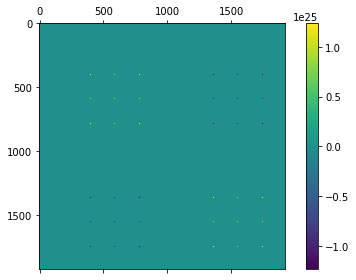

In [20]:
fig, ax = plt.subplots()
im = ax.matshow(test.theta)
cbar = fig.colorbar(im)

fig.tight_layout()
plt.show()